In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import toynet
from evolutions import *
from utils import stack_imgs, dotdict
from evaluation import solve_ode
from train import AdaptiveLoss

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## Define evolution

$$q_t = Be(p_t), p_t = \frac{1}{3}(1+t), 1-p_t = \frac{1}{3}(2-t)$$

In [3]:
def q_t(t):
    t = t.flatten()
    u = torch.rand_like(t)
    p_t = (1+t)/3
    discrete_samples = (u > p_t).float()
    return discrete_samples + torch.rand_like(discrete_samples)

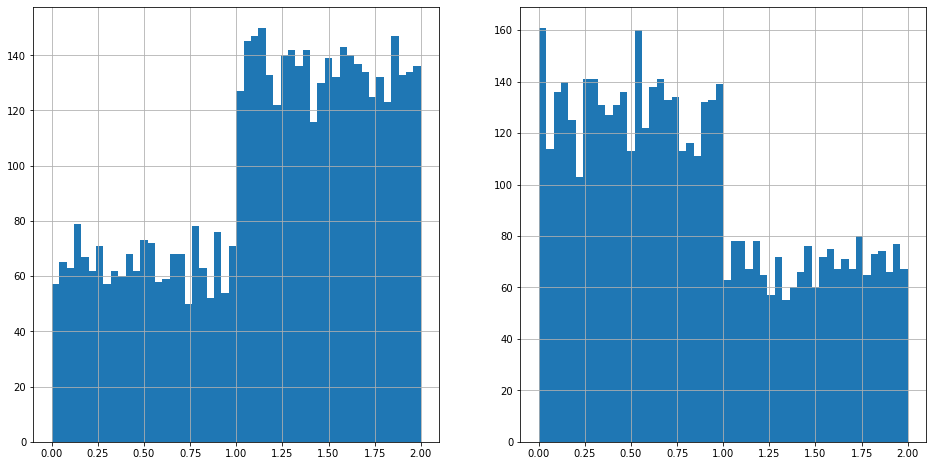

In [33]:
device = torch.device('cuda')

plt.subplot(121)
t = torch.zeros(5000)
_ = plt.hist(q_t(t).numpy(),bins=50)
plt.grid()
plt.subplot(122)
t = torch.ones(5000)
_ = plt.hist(q_t(t).numpy(),bins=50)
plt.grid()

## Learning the potential

$$\int dx\;dt\;q_t\omega_t\bigg[\frac{1}{2}\Vert\nabla s\Vert^2 + \frac{\partial s}{\partial t}\bigg] + \int dx\;dt\; q_ts\frac{\partial \omega_t}{\partial t} - \int dx\;\bigg[ q_1\omega_1s_1 - q_0\omega_0s_0\bigg] \to \min_s$$

In [44]:
net = toynet.SmallMLP(relu=False).to(device)
s = lambda t,x: net(t,x)

def loss_func(n):
    t_0, t_1 = 0.0, 1.0
    t = (torch.rand(1) + np.sqrt(2)*torch.arange(n)) % 1
    t = t.to(device)
    x_t = q_t(t)
    x_t.requires_grad, t.requires_grad = True, True
    s_t = s(t, x_t)
    dsdt, dsdx = torch.autograd.grad(s_t.sum(), [t, x_t], create_graph=True, retain_graph=True)
    x_t, t = x_t.detach(), t.detach()
    
    t_0 = t_0*torch.ones(n).to(device)
    x_0 = q_t(t_0)

    t_1 = t_1*torch.ones(n).to(device)
    x_1 = q_t(t_1)
    
    output = 0.5*(dsdx**2) + dsdt - s(t_1,x_1).squeeze() + s(t_0,x_0).squeeze()
    return output.mean()

In [45]:
torch.manual_seed(1)

optimizer = optim.Adam(net.parameters(), lr=1e-4, betas=(.9, .999))
n_iter = 20000
n_samples = 512
losses = np.zeros(n_iter)
for i in range(n_iter):
    for p in net.parameters(): p.grad = None
    
    loss = loss_func(n_samples)
    loss.backward()
    optimizer.step()
    losses[i] = loss.detach().cpu().numpy()
    if (i % 1000) == 0:
        print('iteration: %d, loss: %.3e' % (i,losses[i]))

iteration: 0, loss: 5.385e-02
iteration: 1000, loss: -6.598e-02
iteration: 2000, loss: -6.035e-02
iteration: 3000, loss: -8.976e-02
iteration: 4000, loss: -8.912e-02
iteration: 5000, loss: -6.309e-02
iteration: 6000, loss: -5.911e-02
iteration: 7000, loss: -5.585e-02
iteration: 8000, loss: -1.055e-01
iteration: 9000, loss: -7.983e-02
iteration: 10000, loss: -7.839e-02
iteration: 11000, loss: -7.820e-02
iteration: 12000, loss: -6.541e-02
iteration: 13000, loss: -7.666e-02
iteration: 14000, loss: -7.750e-02
iteration: 15000, loss: -1.136e-01
iteration: 16000, loss: -5.702e-02
iteration: 17000, loss: -7.182e-02
iteration: 18000, loss: -7.838e-02
iteration: 19000, loss: -4.923e-02


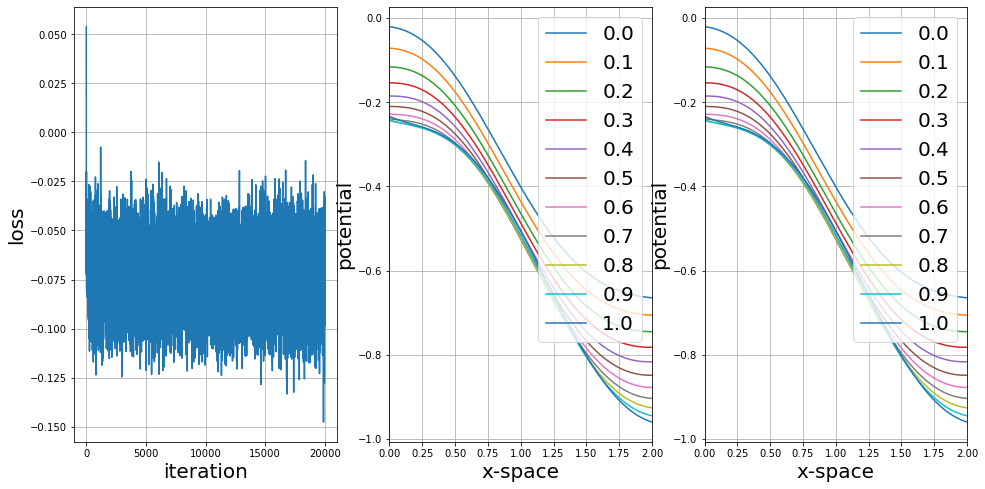

In [46]:
fs = 20

figsize(16,8)
plt.subplot(131)
plt.plot(losses)
plt.xlabel('iteration', fontsize=fs)
plt.ylabel('loss', fontsize=fs)
plt.grid()
plt.subplot(132)
n_points = 200
for i in range(11):
    x = torch.linspace(0.0,2.0,n_points).view(-1,1).to(device)
    t = i/10*torch.ones([n_points,1]).to(device)
    plt.plot(x.cpu().numpy(), s(t,x).detach().cpu().numpy(), label='%.1f' % (i/10))
plt.xlabel('x-space', fontsize=fs)
plt.ylabel('potential', fontsize=fs)
plt.xlim(0.0,2.0)
plt.legend(fontsize=fs)
plt.grid()
plt.subplot(133)
n_points = 200
for i in range(11):
    x = torch.linspace(0.0,2.0,n_points).view(-1,1).to(device)
    t = i/10*torch.ones([n_points,1]).to(device)
    plt.plot(x.cpu().numpy(), net(t,x).detach().cpu().numpy(), label='%.1f' % (i/10))
plt.xlabel('x-space', fontsize=fs)
plt.ylabel('potential', fontsize=fs)
plt.xlim(0.0,2.0)
plt.legend(fontsize=fs)
plt.grid()

## Generation

In [47]:
n_samples = 20000
x_1 = q_t(torch.ones(n_samples))
x_0, nfe = solve_ode(device, s, x_1)

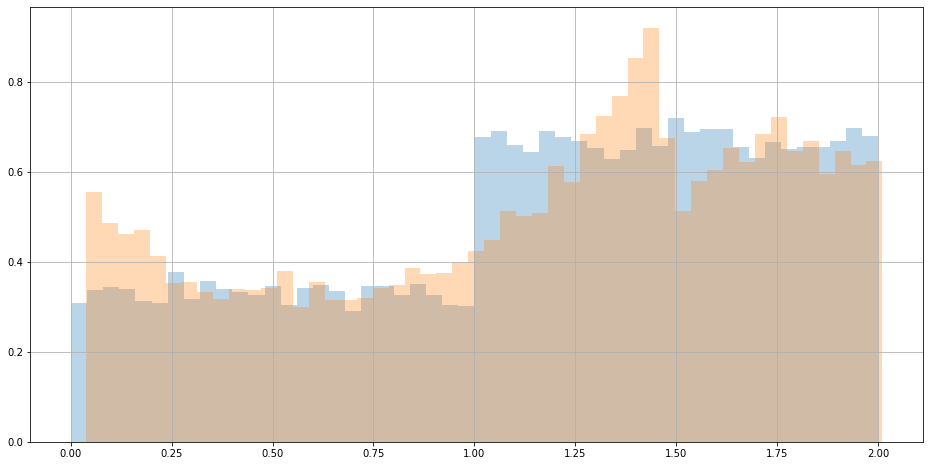

In [48]:
plt.hist(q_t(torch.zeros(n_samples)).cpu().numpy().flatten(), bins=50, density=True, alpha=0.3)
plt.hist(x_0.cpu().numpy().flatten(), bins=50, density=True, alpha=0.3)
plt.grid()

## GIF

In [14]:
n_samples = 4000
x_1 = torch.randn([n_samples,1]).to(device)
frame_ids = list(range(1000))[::5]
frame_ids.append(999)
x_0, x_inter, t_inter = solve_ode(device, s, x_1, frame_ids)

In [27]:
for i in range(len(x_inter)):
    x_t, t = x_inter[i], t_inter[i]
    plt.subplot(121)
    plt.hist(x_t.cpu().numpy().flatten(), bins=40, alpha=0.4, 
             density=True, label=r'$q_{%.3f}$' % t)
    plt.hist(data.cpu().numpy().flatten(), bins=40, alpha=0.4, 
             density=True, label='target')
    plt.xlim(-3,3)
    plt.ylim(0.0,0.5)
    plt.legend(fontsize=fs, loc='upper right')
    plt.grid()

    plt.subplot(122)
    x_plot = torch.linspace(-8,8,n_points).view(-1,1).to(device)
    t_plot = t*torch.ones([n_points, 1]).to(device)
    plt.plot(x_plot.cpu().numpy(), s(t_plot,x_plot).detach().cpu().numpy(), 
             label='%.3f' % t)
    plt.plot()
    plt.ylim(4,9)
    plt.xlim(-3,3)
    plt.legend(fontsize=fs, loc='upper right')
    plt.grid()
    plt.savefig('gifs/simple/%.3d.png' % i, bbox_inches='tight')
    plt.clf()

<Figure size 1152x576 with 0 Axes>

In [28]:
!convert -delay 10 -loop 0 ./gifs/simple/*.png ./gifs/simple.gif